In [52]:
import pandas as pd
from pyarrow import csv
import pyarrow.parquet as pq

# load the parquet file
df = pq.read_table('data/traffic_data.parquet').to_pandas()

# load latlon data
latlon = pd.read_csv('data/latlon.csv')

pop = pd.read_csv('data/population.csv')
# change types to int
pop['year'] = pop['year'].astype(int)
pop['population'] = pop['population'].astype(int)
pop = pop[::-1]
# reverse just the index
pop = pop.reset_index(drop=True)
pop['growth_rate'] = 1
for i in range(len(pop)):
    if i > 0:
        pop['growth_rate'][i] = pop['population'][i] / pop['population'][i-1]

# function that takes in a tuple and returns a list
def tuple_to_list(tup):
    return [tup[0], tup[1]]

# function that takes in a tuple stored as string and returns a tuple
def string_to_tuple(tup_str):
    # remove the parentheses and split by comma
    tup_str = tup_str[1:-1]
    return tuple(map(float, tup_str.split(',')))

latlon["latlon"] = latlon["latlon"].apply(lambda x: string_to_tuple(x))
latlon["latlon"] = latlon["latlon"].apply(lambda x: tuple_to_list(x))

df = df.reset_index()

C:\Users\bence\AppData\Local\Temp\ipykernel_2820\1590911301.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop['growth_rate'][i] = pop['population'][i] / pop['population'][i-1]


In [2]:
# take only date column and columns with T in name
stationAvailability = df[["datetime"] + [col for col in df.columns if " T" in col]]

for station in stationAvailability.columns[1:]:
    # convert to true or false based on value being -1 or else
    stationAvailability.loc[:,station] = stationAvailability.loc[:,station].apply(lambda x: 0 if x == -1 else 1)

stationAvailabilityCopy = stationAvailability.copy()

for station in stationAvailability.columns[1:]:
    stationAvailability.loc[:,station] = stationAvailability.loc[:,station]-stationAvailability.loc[:,station].shift(1)
    stationAvailability.loc[0,station] = 0 if df.loc[0,station] == -1 else 1

# discard all rows where all values are 0
stationAvailability = stationAvailability[abs(stationAvailability.iloc[:, 1:]).sum(axis=1) > 0]

<Figure size 1400x1000 with 0 Axes>

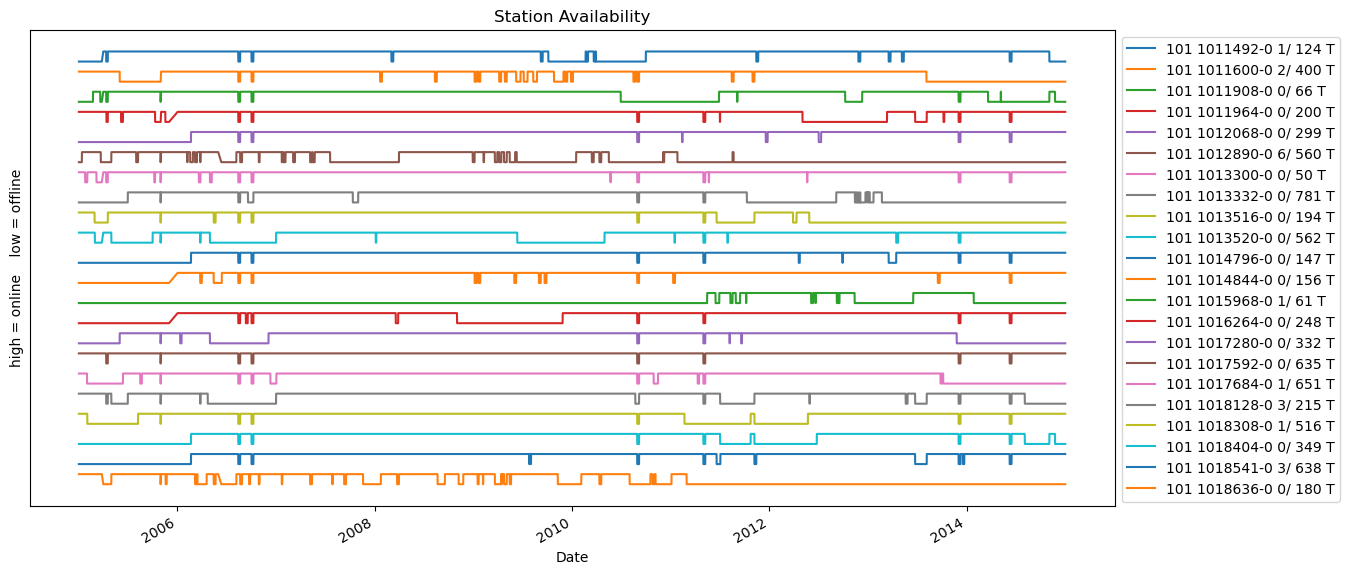

In [3]:
# plot the data
import matplotlib.pyplot as plt

""" 
data = stationAvailability.copy()
i = 0
for col in data.columns[1:]:
    # convert to true or false based on value being -1 or else
    data[col] = data[col] + i
    i -= 4
# scatter plot the data
plt.figure(figsize=(14, 10))
#for station in data.columns[1:]:
#    plt.scatter(data["datetime"], data[station], s=3, alpha=0.5, label=station)
data.plot(x="datetime", figsize=(14, 10), title="Station Availability")
plt.xlabel("Date")
plt.ylabel("Station Availability")
# flip display order of legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
"""

data = stationAvailabilityCopy.copy()
i = 0
for col in data.columns[1:]:
    # convert to true or false based on value being -1 or else
    data[col] = data[col] + i
    i -= 2
# scatter plot the data
plt.figure(figsize=(14, 10))
#for station in data.columns[1:]:
#    plt.scatter(data["datetime"], data[station], s=3, alpha=0.5, label=station)
data.plot(x="datetime", figsize=(14, 7), title="Station Availability")
plt.xlabel("Date")
plt.ylabel("high = online    low = offline")
# hide y ticks
plt.yticks([])
# flip display order of legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))



In [4]:
#print(stationAvailability[stationAvailability.iloc[:,1]!=0.0].iloc[:,0].tolist())

def pairer(l):
    return [(l[i], l[i + 1]) for i in range(0, len(l), 2)]

#pairer(stationAvailability[stationAvailability.iloc[:,1]!=0.0].iloc[:,0].tolist())
#stationAvailability.columns[1]

print(stationAvailability[stationAvailability.iloc[:,1]== 1.0].iloc[:,0].tolist())
print(stationAvailability[stationAvailability.iloc[:,1]==-1.0].iloc[:,0].tolist())
#print(stationAvailability[stationAvailability.iloc[:,1]== 1.0].iloc[:,0].tolist()[0] == pd.Timestamp("2005-01-01 00:00:00"))
#print(stationAvailability[stationAvailability.iloc[:,1]== 1.0].iloc[:,0].tolist()[0] == pd.Timestamp("2005-01-01 00:00:00"))
print(pd.Timestamp("2019-01-01 01:00:00") > pd.Timestamp("2019-01-01 00:00:00"))

def onoffpairs(on,off):
    startsAsOn = on[0] == pd.Timestamp("2005-01-01 00:00:00")
    endsAsOn = on[-1] > off[-1]

    if not(startsAsOn):
        off = [pd.Timestamp("2005-01-01 00:00:00")] + off
    if endsAsOn:
        off = off + [pd.Timestamp("2014-12-31 00:00:00")]
    else:
        on = on + [pd.Timestamp("2014-12-31 00:00:00")]
    
    online = []
    offline = []

    #print(startsAsOn, endsAsOn)

    if startsAsOn and endsAsOn:
        for i in range(len(on)-1):
            online  += [[on[i], off[i]]]
            offline += [[off[i], on[i+1]]]
        online += [[on[-1], off[-1]]]

    elif not(startsAsOn) and not(endsAsOn):
        for i in range(len(off)-1):
            offline += [[off[i], on[i]]]
            online  += [[on[i], off[i+1]]]
        offline += [[off[-1], on[-1]]]

    elif startsAsOn and not(endsAsOn):
        for i in range(len(on)-1):
            online  += [[on[i], off[i]]]
            offline += [[off[i], on[i+1]]]
    
    elif not(startsAsOn) and endsAsOn:
        for i in range(len(off)-1):
            offline += [[off[i], on[i]]]
            online  += [[on[i], off[i+1]]]
    
    return online, offline


[Timestamp('2005-04-01 00:00:00'), Timestamp('2005-04-18 00:00:00'), Timestamp('2006-08-21 00:00:00'), Timestamp('2006-10-09 00:00:00'), Timestamp('2008-03-10 00:00:00'), Timestamp('2009-09-14 00:00:00'), Timestamp('2010-02-20 00:00:00'), Timestamp('2010-03-01 00:00:00'), Timestamp('2010-03-28 00:00:00'), Timestamp('2010-10-01 00:00:00'), Timestamp('2011-11-21 00:00:00'), Timestamp('2012-12-03 00:00:00'), Timestamp('2013-03-25 00:00:00'), Timestamp('2013-05-13 00:00:00'), Timestamp('2014-06-16 00:00:00')]
[Timestamp('2005-04-12 00:00:00'), Timestamp('2006-08-14 00:00:00'), Timestamp('2006-10-02 00:00:00'), Timestamp('2008-03-03 00:00:00'), Timestamp('2009-09-07 00:00:00'), Timestamp('2009-10-05 00:00:00'), Timestamp('2010-02-22 00:00:00'), Timestamp('2010-03-22 00:00:00'), Timestamp('2010-03-30 00:00:00'), Timestamp('2011-11-14 00:00:00'), Timestamp('2012-11-26 00:00:00'), Timestamp('2013-03-18 00:00:00'), Timestamp('2013-05-06 00:00:00'), Timestamp('2014-06-09 00:00:00'), Timestamp('2

In [5]:
#[x.strftime("%Y-%m-%dT%H:%M:%S") for x in onoffpairs(stationAvailability[stationAvailability.iloc[:,1]== 1.0].iloc[:,0].tolist(), stationAvailability[stationAvailability.iloc[:,1]==-1.0].iloc[:,0].tolist())[0][0]]

#latlon[latlon["Vej-Id"] == stationAvailability.columns[1]]["latlon"].tolist()[0][::-1]

#stationAvailability[stationAvailability.columns[1]]

#stationAvailability.columns[len(stationAvailability.columns[1:])]

#stationAvailability.iloc[1,0].strftime("%Y-%m-%dT%H:%M:%S")

#stations = set(latlon["latlon"].apply(lambda x: tuple(x)))
#stations = list(stations)
#stations = [tuple_to_list(tup) for tup in stations]

In [65]:
import folium.plugins
import folium

m = folium.Map(location=[55.65184, 12.55388], zoom_start=12)

points = []

for i in range(len(stationAvailability.columns[1:])-1):
    pointpairs = onoffpairs(stationAvailability[stationAvailability.iloc[:,i+1]== 1.0].iloc[:,0].tolist(), stationAvailability[stationAvailability.iloc[:,i+1]==-1.0].iloc[:,0].tolist())
    points += [
        {
            "order" : on[0] + pd.Timedelta(seconds=i),
            "coordinates" :  latlon[latlon["Vej-Id"] == stationAvailability.columns[i+1]]["latlon"].tolist()[0][::-1],
            "times": [time.strftime("%Y-%m-%dT%H:%M:%S") for time in on],
            "color": "green",
        }
        for on in pointpairs[0]
    ]
    points += [
        {
            "order" : off[0] + pd.Timedelta(seconds=i),
            "coordinates" :  latlon[latlon["Vej-Id"] == stationAvailability.columns[i+1]]["latlon"].tolist()[0][::-1],
            "times": [time.strftime("%Y-%m-%dT%H:%M:%S") for time in off],
            "color": "red",
        }
        for off in pointpairs[1]
    ]

def order_json_elements(json_list):
    return sorted(json_list, key=lambda x: x["order"])

points = order_json_elements(points)

features = [
    {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": point["coordinates"],
        },
        "properties": {
            "times": point["times"],
            "icon": "circle",
            "iconstyle": {
                "fillColor": point["color"],
                "fillOpacity": 1.0,
                "stroke": True,
                "radius": 5,
                "color": point["color"],
            },
        },
    }
    for point in points
]

folium.plugins.TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features,
    },
    period="P1D",  # Skip days for each frame
    max_speed=31,
    add_last_point=True,
).add_to(m)

m


In [8]:
import math
import numpy as np

def approx_distance(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    lat_factor = 111320  # Meters per degree latitude
    lon_factor = 111320 * math.cos(math.radians(lat1))  # Adjust for latitude

    dx = (lon2 - lon1) * lon_factor
    dy = (lat2 - lat1) * lat_factor

    return math.sqrt(dx**2 + dy**2)


# I needed extra coordinates with an offset detailing the direction of the road for each station
# for this I went through google maps and selected a station and a point near the station for each road
# since I didn't exactly click on the station I had to match my coordinates to the station coordinates
directions = pd.read_csv('data/directions.csv')

# formatting the csv a bit better
directions['latlon1'] = directions.apply(lambda row: [row['lat1'], row['lon1']], axis=1)
directions['latlon2'] = directions.apply(lambda row: [row['lat2'], row['lon2']], axis=1)

# drop the lat and lon columns
directions = directions.drop(columns=['lat1', 'lon1', 'lat2', 'lon2'])

# get column with a coordinate that I treat as a basis vector for road direction
# now I can draw lines on the road from each station by multiplying delta and adding it to the station coordinates
directions['delta'] = directions['latlon2'].apply(lambda x: np.array(x)) - directions['latlon1'].apply(lambda x: np.array(x))
directions['distance'] = directions.apply(lambda row: approx_distance(row['latlon1'], row['latlon2']), axis=1)
directions['delta'] = directions.apply(lambda row: [row['delta'][0]/row['distance'], row['delta'][1]/row['distance']], axis=1)


# this function takes in a dataframe with coordinates and matches them to the nearest coordinates in another dataframe
def simple_match_nearest(df_ref, df_target, coord_col_ref='coord', coord_col_target='coord'):

    ref_coords = np.vstack(df_ref[coord_col_ref].values)
    target_coords = np.vstack(df_target[coord_col_target].values)

    matches = []
    for ref_point in ref_coords:
        distances = np.linalg.norm(target_coords - ref_point, axis=1)
        idx = np.argmin(distances)
        match_row = df_target.iloc[idx].copy()
        match_row['matched_distance'] = distances[idx]
        matches.append(match_row)

    matched_df = df_ref.reset_index(drop=True).copy()
    matched_data = pd.DataFrame(matches).reset_index(drop=True)
    result = pd.concat([matched_df, matched_data.add_prefix("matched_")], axis=1)

    return result

matching0 = simple_match_nearest(latlon, directions, 'latlon', 'latlon1')

In [9]:
# plot that tests wether delta coordinates are correctly scaled despite lat lon distortion

def circle_coordinates(center, radius, num_points, distort=False):
    lat, lon = center
    coordinates = []
    for i in range(num_points+1):
        angle = 2 * math.pi * i / num_points
        dx = radius * math.cos(angle)
        dy = radius * math.sin(angle)
        if distort:
            coordinates.append([lat + dy / 111320, lon + dx / (111320)])
        else:
            coordinates.append([lat + dy / 111320, lon + dx / (111320 * math.cos(math.radians(lat)))])
    return coordinates

# create a circle in copenhagen
circle1 = circle_coordinates([55.65184, 12.55388], 1000, 30)
circle2 = circle_coordinates([55.65184, 12.55388], 1000, 30, distort=True)


m = folium.Map(location=[55.65184, 12.55388], zoom_start=12)

folium.PolyLine(circle1, color="blue", weight=2.5, opacity=1).add_to(m)
folium.PolyLine(circle2, color="red", weight=2.5, opacity=1).add_to(m)

# load points from the deltas
for point in directions['delta'].tolist():
    point = [point[0]*1000, point[1]*1000]
    point = [point[0]+55.65184, point[1]+12.55388]
    folium.Marker(location=point, popup="Marker").add_to(m)

for point in directions['delta'].tolist():
    point = [point[0]*-1000, point[1]*-1000]
    point = [point[0]+55.65184, point[1]+12.55388]
    folium.Marker(location=point, popup="Marker").add_to(m)

m

In [ ]:
# 1 day traffic animation with colour scale uniform across all stations

from folium.plugins import TimestampedGeoJson

lilD = matching0[matching0["Vej-Id"].str.endswith(" T")].copy()

def listVadd(l1, l2,mult=1):
    return [l1[0]+l2[0]*mult, l1[1]+l2[1]*mult]

m = folium.Map(location=[55.68574, 12.571037], zoom_start=12, tiles="Cartodb Positron")
w = 5

lilData = df[df["datetime"] >= pd.Timestamp("2008-01-01 00:00:00")].copy()
lilData = lilData[lilData["datetime"] <= pd.Timestamp("2008-01-02 00:00:00")].copy()

# drop all columns by some condition
lilData = lilData.drop(columns=[col for col in lilData.columns[1:] if "101" not in col])
maximum = np.array(lilData[lilData.columns[~lilData.columns.str.contains(" T")]].max().tolist()[1:]).max()
lilData.iloc[:,1:] = (lilData.iloc[:,1:]/maximum)*600


#lilData['feature'] = lildata.apply(data2features, axis=1)

features = []
lines = []


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def count2color(count):
    if count < 0:
        return "#000000"  # Black for negative values
    norm = mcolors.Normalize(vmin=0, vmax=600)
    #cmap = plt.cm.get_cmap("jet")
    cmap = plt.colormaps.get_cmap("jet")
    rgba = cmap(norm(count))
    return mcolors.to_hex(rgba)

for index, row in lilData.iterrows():
    for col in lilData.columns[1:]:
        count = row[col]
        point = matching0[matching0['Vej-Id'] == col]['latlon'].tolist()[0][::-1]
        delta = matching0[matching0['Vej-Id'] == col]['matched_delta'].tolist()[0][::-1]
        times = [time.strftime("%Y-%m-%dT%H:%M:%S") for time in [row['datetime'], row['datetime']+pd.Timedelta(seconds=1)]]
        if col.endswith("+"):
            #folium.PolyLine([point, listVadd(point,delta,600)], color="white", weight=w, opacity=1, times=[row['datetime']]*2).add_to(m)
            #folium.PolyLine([listVadd(point,delta,0), listVadd(point,delta,count)], color="red", weight=w, opacity=1, times=[row['datetime']]*2).add_to(m)
            lines.append({
                "order": row['datetime'],
                "coordinates" : [point, listVadd(point,delta,600)],
                "color": "white",
                "times": times,
            })
            lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=1),
                "coordinates" : [point, listVadd(point,delta,count)],
                "color": count2color(count),
                "times": times,
            })
        elif col.endswith("-"):
            #folium.PolyLine([point, listVadd(point,delta,-600)], color="white", weight=w, opacity=1, times=[row['datetime']]*2).add_to(m)
            #folium.PolyLine([listVadd(point,delta,0), listVadd(point,delta,-count)], color="blue", weight=w, opacity=1, times=[row['datetime']]*2).add_to(m)
            lines.append({
                "order": row['datetime'],
                "coordinates" : [point, listVadd(point,delta,-600)],
                "color": "white",
                "times": times,
            })
            lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=1),
                "coordinates" : [point, listVadd(point,delta,-count)],
                "color": count2color(count),
                "times": times,
            })
        elif col.endswith(" T"):
            #folium.CircleMarker(location=point,radius=4,color="green", fillColor="green", fillOpacity=1.0, times=[row['datetime']]*2).add_to(m)
            if count >= 0:
                lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=2),
                "coordinates" : [point, point],
                "color": "white",
                "times": times,
            })
            else:
                lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=2),
                "coordinates" : [point, point],
                "color": "red",
                "times": times,
            })

def order_json_elements(json_list):
    return sorted(json_list, key=lambda x: x["order"])

lines = order_json_elements(lines)

features = [{
                "type": "Feature",
                "geometry": {
                    "type": "LineString",
                    "coordinates": line["coordinates"],
                },
                "properties": {
                    "times": line["times"],
                    "style": {"color": line["color"], "weight": w}
                }
            } for line in lines ]

TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features
    },
    period="PT1H",
    add_last_point=False,
    transition_time=200,
    loop=True,
    auto_play=True,
    loop_button=True,
    time_slider_drag_update=True,
).add_to(m)

m

In [175]:
#np.array(lilData[lilData.columns[~lilData.columns.str.contains(" T")]].max().tolist()[1:])*100
# here I was working out how to met max traffic value in both direction then dividing both by the same value
# I didn't use max value of Total because that will be higher than both directions leading to the line
# not using the full scale
""" 

print(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[1:])

print(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[1::3])
print(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[2::3])
print(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[3::3])

print(np.array([lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[1::3],
      lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[2::3]]).max(axis=0))

lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].iloc[:,2::3]

"""

' \n\nprint(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[1:])\n\nprint(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[1::3])\nprint(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[2::3])\nprint(lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[3::3])\n\nprint(np.array([lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[1::3],\n      lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].max().tolist()[2::3]]).max(axis=0))\n\nlilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]].iloc[:,2::3]\n\n'

In [ ]:
# 1 day traffic animation with colour scale unique to each stations own range

from folium.plugins import TimestampedGeoJson

lilD = matching0[matching0["Vej-Id"].str.endswith(" T")].copy()

def listVadd(l1, l2,mult=1):
    return [l1[0]+l2[0]*mult, l1[1]+l2[1]*mult]

m = folium.Map(location=[55.68574, 12.571037], zoom_start=12, tiles="Cartodb Positron")
w = 5

lilData = df[df["datetime"] >= pd.Timestamp("2008-01-01 00:00:00")].copy()
lilData = lilData[lilData["datetime"] <= pd.Timestamp("2008-01-02 00:00:00")].copy()

# drop all columns by some condition
lilData = lilData.drop(columns=[col for col in lilData.columns[1:] if "101" not in col])
lilData = lilData[lilData.columns[~lilData.columns.str.contains("101 1015968-0 1/ 61")]]
maximums = np.array([lilData.max().tolist()[1::3],
                     lilData.max().tolist()[2::3]]).max(axis=0)
lilData.iloc[:,1::3] = lilData.iloc[:,1::3].apply(lambda x: (x/abs(x.max())*600), axis=0)
lilData.iloc[:,2::3] = lilData.iloc[:,2::3].apply(lambda x: (x/abs(x.max())*600), axis=0)


#lilData['feature'] = lildata.apply(data2features, axis=1)

features = []
lines = []


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def count2color(count):
    if count < 0:
        return "#FFFFFF"  # Black for negative values
    norm = mcolors.Normalize(vmin=0, vmax=600)
    #cmap = plt.cm.get_cmap("jet")
    cmap = plt.colormaps.get_cmap("jet")
    rgba = cmap(norm(count))
    return mcolors.to_hex(rgba)

for index, row in lilData.iterrows():
    for col in lilData.columns[1:]:
        count = row[col]
        point = matching0[matching0['Vej-Id'] == col]['latlon'].tolist()[0][::-1]
        delta = matching0[matching0['Vej-Id'] == col]['matched_delta'].tolist()[0][::-1]
        times = [time.strftime("%Y-%m-%dT%H:%M:%S") for time in [row['datetime'], row['datetime']+pd.Timedelta(seconds=1)]]
        if col.endswith("+"):
            #folium.PolyLine([point, listVadd(point,delta,600)], color="white", weight=w, opacity=1, times=[row['datetime']]*2).add_to(m)
            #folium.PolyLine([listVadd(point,delta,0), listVadd(point,delta,count)], color="red", weight=w, opacity=1, times=[row['datetime']]*2).add_to(m)
            lines.append({
                "order": row['datetime'],
                "coordinates" : [point, listVadd(point,delta,600)],
                "color": "white",
                "times": times,
            })
            lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=1),
                "coordinates" : [point, listVadd(point,delta,count)],
                "color": count2color(count),
                "times": times,
            })
        elif col.endswith("-"):
            #folium.PolyLine([point, listVadd(point,delta,-600)], color="white", weight=w, opacity=1, times=[row['datetime']]*2).add_to(m)
            #folium.PolyLine([listVadd(point,delta,0), listVadd(point,delta,-count)], color="blue", weight=w, opacity=1, times=[row['datetime']]*2).add_to(m)
            lines.append({
                "order": row['datetime'],
                "coordinates" : [point, listVadd(point,delta,-600)],
                "color": "white",
                "times": times,
            })
            lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=1),
                "coordinates" : [point, listVadd(point,delta,-count)],
                "color": count2color(count),
                "times": times,
            })
        elif col.endswith(" T"):
            #folium.CircleMarker(location=point,radius=4,color="green", fillColor="green", fillOpacity=1.0, times=[row['datetime']]*2).add_to(m)
            if count >= 0:
                lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=2),
                "coordinates" : [point, point],
                "color": "white",
                "times": times,
            })
            else:
                lines.append({
                "order": row['datetime']+pd.Timedelta(seconds=2),
                "coordinates" : [point, point],
                "color": "red",
                "times": times,
            })

def order_json_elements(json_list):
    return sorted(json_list, key=lambda x: x["order"])

lines = order_json_elements(lines)

features = [{
                "type": "Feature",
                "geometry": {
                    "type": "LineString",
                    "coordinates": line["coordinates"],
                },
                "properties": {
                    "times": line["times"],
                    "style": {"color": line["color"], "weight": w}
                }
            } for line in lines ]

TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features
    },
    period="PT1H",
    add_last_point=False,
    transition_time=200,
    loop=True,
    auto_play=True,
    loop_button=True,
    time_slider_drag_update=True,
).add_to(m)

m

Just experiments from here on #################################################################

In [ ]:
# this was prototype without the time series implemented

lilD = matching0[matching0["Vej-Id"].str.endswith(" T")].copy()

def listVadd(l1, l2,mult=1):
    return [l1[0]+l2[0]*mult, l1[1]+l2[1]*mult]

m = folium.Map(location=[55.65184, 12.55388], zoom_start=12)

w = 5
for index, row in lilD.iterrows():
    point = row['latlon']
    delta = row['matched_delta']

    folium.PolyLine([point, listVadd(point,delta,600)], color="white", weight=w, opacity=1).add_to(m)
    folium.PolyLine([point, listVadd(point,delta,-600)], color="white", weight=w, opacity=1).add_to(m)
    # seems like some of the white lines get drawn over the coloured ones of other stations, could be solved by looping over
    # the stations twice for background white and coloured data, folium is so amazing (gazez outside window with longing for the sun)

    folium.PolyLine([listVadd(point,delta,0), listVadd(point,delta,300)], color="red", weight=w, opacity=1).add_to(m)
    folium.PolyLine([listVadd(point,delta,0), listVadd(point,delta,-300)], color="blue", weight=w, opacity=1).add_to(m)
    # later this could be colourmapped also, something like jet could be cool

    folium.CircleMarker(location=point,radius=4,color="green", fillColor="green", fillOpacity=1.0).add_to(m)
    # This is drawn because the thickness of one line will cover up the start of the other and lead to it looking longer
    # than it should be :)))))))) I will drag folium across the finish line by it's hair if I have to I swear to god I will


m

In [56]:
# make latlon a dictionary with the key being the station id
#latlon = latlon.set_index('Vej-Id').T.to_dict('list')

#latlon[latlon['Vej-Id'] == '101 1011492-0 1/ 124 +']['latlon'].tolist()[0]
matching0[matching0['Vej-Id'] == '101 1011492-0 1/ 124 +']['latlon'].tolist()[0]

[55.65054271299065, 12.510778460442603]

In [ ]:
# prototype on force clearing lines by drawing them in white

import folium
from folium.plugins import TimestampedGeoJson
import datetime

# Map center
center = [55.6761, 12.5683]
base_lat = center[0]
spacing = 0.005
start_time = datetime.datetime.utcnow()

features = []
line_color = "red"
erase_color = "white"  # Or use the map background color


for i in range(3):
    lat = base_lat + i * spacing
    coords = [
        [center[1] - 0.01, lat],
        [center[1] + 0.01, lat]
    ]

    appear_t0 = (start_time + datetime.timedelta(seconds=i * 2)).isoformat() + "Z"
    appear_t1 = (start_time + datetime.timedelta(seconds=i * 2 + 1)).isoformat() + "Z"

    erase_t0 = (start_time + datetime.timedelta(seconds=i * 2 + 1)).isoformat() + "Z"
    erase_t1 = (start_time + datetime.timedelta(seconds=i * 2 + 2)).isoformat() + "Z"

    # Red line (original)
    features.append({
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": coords
        },
        "properties": {
            "times": [appear_t0, appear_t1],
            "style": {"color": line_color, "weight": 4}
        }
    })

    # White line (eraser)
    features.append({
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": coords
        },
        "properties": {
            "times": [erase_t0, erase_t1],
            "style": {"color": erase_color, "weight": 5}
        }
    })

# Build the map
m = folium.Map(location=[55.65184, 12.55388], zoom_start=12)

TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features
    },
    period="PT1S",
    add_last_point=False,
    transition_time=200,
    loop=True,
    auto_play=True,
    loop_button=True,
    time_slider_drag_update=True,
).add_to(m)

#m.save("folium_animated_lines_erase.html")
m


In [ ]:
""" 

import folium.plugins
import folium

m = folium.Map(location=[35.68159659061569, 139.76451516151428], zoom_start=16)

# Lon, Lat order.
lines = [
    {
        "coordinates": [
            [139.76451516151428, 35.68159659061569],
            [139.75964426994324, 35.682590062684206],
        ],
        "dates": ["2017-06-02T00:00:00", "2017-06-02T00:10:00"],
        "color": "red",
    },
    {
        "coordinates": [
            [139.75964426994324, 35.682590062684206],
            [139.7575843334198, 35.679505030038506],
        ],
        "dates": ["2017-06-02T00:10:00", "2017-06-02T00:20:00"],
        "color": "blue",
    },
    {
        "coordinates": [
            [139.7575843334198, 35.679505030038506],
            [139.76337790489197, 35.678040905014065],
        ],
        "dates": ["2017-06-02T00:20:00", "2017-06-02T00:30:00"],
        "color": "green",
        "weight": 15,
    },
    {
        "coordinates": [
            [139.76337790489197, 35.678040905014065],
            [139.76451516151428, 35.68159659061569],
        ],
        "dates": ["2017-06-02T00:30:00", "2017-06-02T00:40:00"],
        "color": "#FFFFFF",
    },
]

features = [
    {
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": line["coordinates"],
        },
        "properties": {
            "times": line["dates"],
            "style": {
                "color": line["color"],
                "weight": line["weight"] if "weight" in line else 5,
            },
        },
    }
    for line in lines
]

points = [
    {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": line["coordinates"][0],
        },
        "properties": {
            "times": [line["dates"][0]],
            "icon": "circle",
            "iconstyle": {
                "fillColor": line["color"],
                "fillOpacity": 0.9,
                "stroke": True,
                "radius": 10,
                "color": "#000000",
            },
        },
    }
    for line in lines
]

points = [
    
    {
        "coordinates" :  [139.76337790489197, 35.678040905014065],
        "times": ["2017-06-02T00:30:00", "2017-06-02T00:40:00"],
        "color": "red",
    },
    {
        "coordinates" :  [139.76337790489197, 35.678040905014065],
        "times": ["2017-06-02T00:00:00", "2017-06-02T00:10:00"],
        "color": "green",
    },
    {
        "coordinates" :  [139.76337790489197, 35.678040905014065],
        "times": ["2017-06-02T00:10:00", "2017-06-02T00:20:00"],
        "color": "red",
    },
    {
        "coordinates" :  [139.76337790489197, 35.678040905014065],
        "times": ["2017-06-02T00:20:00", "2017-06-02T00:30:00"],
        "color": "green",
    },
    
]

features += [
    {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": point["coordinates"],
        },
        "properties": {
            "times": point["times"],
            "icon": "circle",
            "iconstyle": {
                "fillColor": point["color"],
                "fillOpacity": 1.0,
                "stroke": True,
                "radius": 10,
                "color": "#000000",
            },
        },
    }
    for point in points
]



folium.plugins.TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features,
    },
    period="PT1M",
    add_last_point=True,
).add_to(m)

m


"""


' \n\nimport folium.plugins\nimport folium\n\nm = folium.Map(location=[35.68159659061569, 139.76451516151428], zoom_start=16)\n\n# Lon, Lat order.\nlines = [\n    {\n        "coordinates": [\n            [139.76451516151428, 35.68159659061569],\n            [139.75964426994324, 35.682590062684206],\n        ],\n        "dates": ["2017-06-02T00:00:00", "2017-06-02T00:10:00"],\n        "color": "red",\n    },\n    {\n        "coordinates": [\n            [139.75964426994324, 35.682590062684206],\n            [139.7575843334198, 35.679505030038506],\n        ],\n        "dates": ["2017-06-02T00:10:00", "2017-06-02T00:20:00"],\n        "color": "blue",\n    },\n    {\n        "coordinates": [\n            [139.7575843334198, 35.679505030038506],\n            [139.76337790489197, 35.678040905014065],\n        ],\n        "dates": ["2017-06-02T00:20:00", "2017-06-02T00:30:00"],\n        "color": "green",\n        "weight": 15,\n    },\n    {\n        "coordinates": [\n            [139.763377

In [ ]:
import folium
from folium.plugins import TimestampedGeoJson
import datetime

# Map center
center = [55.6761, 12.5683]
base_lat = center[0]
spacing = 0.005
start_time = datetime.datetime.utcnow()

features = []
line_color = "red"
erase_color = "white"  # Or use the map background color

for i in range(3):
    lat = base_lat + i * spacing
    coords = [
        [center[1] - 0.01, lat],
        [center[1] + 0.01, lat]
    ]

    appear_t0 = (start_time + datetime.timedelta(seconds=i * 2)).isoformat() + "Z"
    appear_t1 = (start_time + datetime.timedelta(seconds=i * 2 + 1)).isoformat() + "Z"

    erase_t0 = (start_time + datetime.timedelta(seconds=i * 2 + 1)).isoformat() + "Z"
    erase_t1 = (start_time + datetime.timedelta(seconds=i * 2 + 2)).isoformat() + "Z"

    # Red line (original)
    features.append({
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": coords
        },
        "properties": {
            "times": [appear_t0, appear_t1],
            "style": {"color": line_color, "weight": 4}
        }
    })

    # White line (eraser)
    features.append({
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": coords
        },
        "properties": {
            "times": [erase_t0, erase_t1],
            "style": {"color": erase_color, "weight": 5}
        }
    })

# Build the map
m = folium.Map(location=center, zoom_start=13)


TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features
    },
    period="PT1S",
    add_last_point=False,
    transition_time=200,
    loop=True,
    auto_play=True,
    loop_button=True,
    time_slider_drag_update=True,
).add_to(m)

#m.save("folium_animated_lines_erase.html")
m
